# Regression Analysis

## Step 0: Import Libraries

In [25]:
# Notebook setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

RANDOM_STATE = 42
pd.set_option("display.precision", 3)

## Step 1: Load Data

In [ ]:
# File
df = pd.read_pickle("../data/modeling.dataset.pkl")
print(df.shape)
df.head()

## Step 2: Define target and guard against leakage

In [26]:
# Define target and guard against leakage
# Numeric target for regression 
TARGET = "graduation_rate"

# Columns that leak
LEAKAGE = [
    "graduation_rate",   # the target itself
    "high_grad_rate",    # categorical version
    "low_grad_rate"      # inverse categorical version
]

# (Optional) drop identifiers/size-like columns if present & not desired as predictors
OPTIONAL_DROP = [
    "cdscode",           # id-like
    "county",            # categorical text
    "cohortstudents"     # size of cohort; drop if acting like proxy for target
]

to_drop = [c for c in LEAKAGE + OPTIONAL_DROP if c in df.columns]

# X, y
y = df[TARGET].astype(float)
X = df.drop(columns=to_drop, errors="ignore")

print("X shape before numeric filtering:", X.shape)

X shape before numeric filtering: (958, 24)


## Step 3: Keep only numeric features (models need numbers)

In [27]:
X = X.select_dtypes(include=[np.number])
print("X shape after numeric filtering:", X.shape)

# Quick missingness check
missing_pct = X.isna().mean().sort_values(ascending=False)
missing_pct[missing_pct > 0].head(10)

X shape after numeric filtering: (958, 24)


Series([], dtype: float64)

## Step 4: Train/validation split (no stratify for regression)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((766, 24), (192, 24))

## Step 5: Preprocess: impute + (optionally) scale for linear models

In [29]:
# We'll build two pipelines: 
#   - lin_pipe: SimpleImputer + StandardScaler (+ specific linear model)
#   - tree_pipe: SimpleImputer only (trees don’t need scaling)

lin_prep = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

tree_prep = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

## Step 6: Models

In [30]:
models = {
    # Baseline
    "Dummy Mean": Pipeline([
        ("prep", tree_prep),
        ("clf", DummyRegressor(strategy="mean"))
    ]),
    
    # Linear family (scaled)
    "Linear Regression": Pipeline([
        ("prep", lin_prep),
        ("clf", LinearRegression())
    ]),
    "RidgeCV": Pipeline([
        ("prep", lin_prep),
        ("clf", RidgeCV(alphas=np.logspace(-3, 3, 25)))
    ]),
    "LassoCV": Pipeline([
        ("prep", lin_prep),
        ("clf", LassoCV(alphas=None, cv=5, random_state=RANDOM_STATE, max_iter=10000))
    ]),
    "ElasticNetCV": Pipeline([
        ("prep", lin_prep),
        ("clf", ElasticNetCV(l1_ratio=[.1,.3,.5,.7,.9,.95,.99,1.0], cv=5, random_state=RANDOM_STATE, max_iter=10000))
    ]),
    
    # Tree ensemble (no scaling)
    "Random Forest": Pipeline([
        ("prep", tree_prep),
        ("clf", RandomForestRegressor(
            n_estimators=400, min_samples_leaf=3, n_jobs=-1, random_state=RANDOM_STATE
        ))
    ]),
}

## Step 7: Fit/evaluate all models

In [31]:
def evaluate(name, pipe, X_tr, y_tr, X_te, y_te):
    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_te)
    mae  = mean_absolute_error(y_te, pred)
    rmse = np.sqrt(mean_squared_error(y_te, pred))
    r2   = r2_score(y_te, pred)
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

results = []
for name, pipe in models.items():
    results.append(evaluate(name, pipe, X_train, y_train, X_test, y_test))

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False).reset_index(drop=True)
results_df

c:\Users\tanya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(


,Model,MAE,RMSE,R2
0,Random Forest,2.839,4.037,0.643
1,RidgeCV,2.918,4.263,0.602
2,Linear Regression,2.940,4.276,0.600
3,LassoCV,2.965,4.292,0.597
4,ElasticNetCV,2.965,4.292,0.597
5,Dummy Mean,5.029,6.765,-0.002


## Step 8: Bar chart (R²)

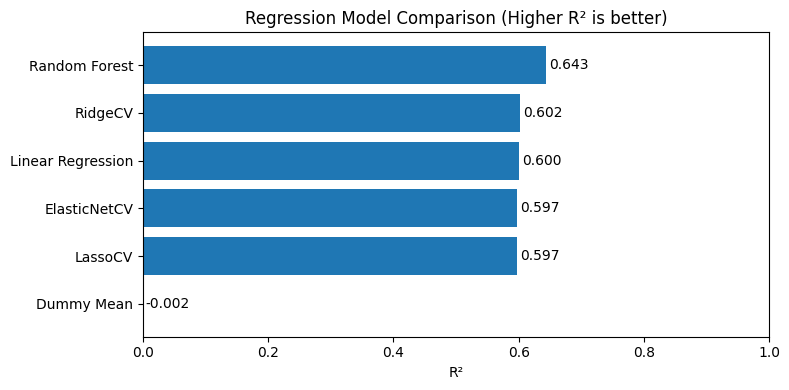

In [32]:
plt.figure(figsize=(8,4))
ordered = results_df.sort_values(by="R2", ascending=True)
plt.barh(ordered["Model"], ordered["R2"])
for i, v in enumerate(ordered["R2"]):
    plt.text(v + 0.005, i, f"{v:.3f}", va="center")
plt.xlabel("R²")
plt.title("Regression Model Comparison (Higher R² is better)")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

## Step 9: (Optional) Feature importance from Random Forest

In [33]:
rf_pipe = models["Random Forest"]
rf_pipe.fit(X_train, y_train)

rf_model = rf_pipe.named_steps["clf"]
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

importances.head(15)

still_enrolled_rate           0.460
chronicabsenteeismrate        0.114
unexcused_absences_percent    0.062
stu_tch_ratio                 0.056
met_uccsu_grad_reqs_rate      0.045
percent__eligible_free_k12    0.043
frpm_count_k12                0.029
pct_senior_cohort             0.028
grade_retention_ratio         0.020
pct_bachelors                 0.016
stu_adm_ratio                 0.015
stu_psv_ratio                 0.015
pct_experienced               0.014
pct_doctorate                 0.011
pct_master                    0.011
dtype: float64

## Step 10: (Optional) Residual diagnostics for the top model

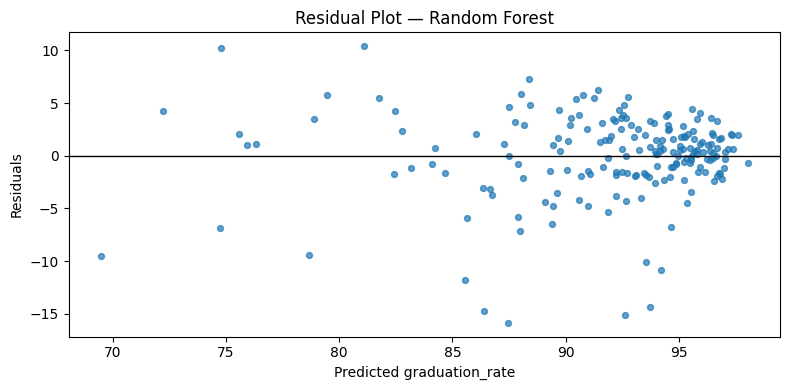

,y_true,y_pred,residual
928,86.1,89.627,-3.527
535,98.5,96.484,2.016
388,93.4,91.928,1.472
992,98.3,92.755,5.545
954,97.0,95.921,1.079
294,88.7,90.039,-1.339
246,99.3,97.332,1.968
371,96.7,97.045,-0.345
92,100.0,95.595,4.405
976,94.2,94.846,-0.646


In [34]:
best_name = results_df.iloc[0]["Model"]
best_pipe = models[best_name].fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)
resid = y_test - y_pred

plt.figure(figsize=(8,4))
plt.scatter(y_pred, resid, s=18, alpha=0.7)
plt.axhline(0, color="black", lw=1)
plt.xlabel("Predicted graduation_rate")
plt.ylabel("Residuals")
plt.title(f"Residual Plot — {best_name}")
plt.tight_layout()
plt.show()

pd.DataFrame({"y_true": y_test, "y_pred": y_pred, "residual": resid}).head(10)

## Summary:


**Random forest** was the most effective of all the evaluated regression models with an R-squared of .64, which means it accounts for about 64% of the variation in graduation rate data; **Random Forest** also produced the least mean absolute error (MAE) and root mean squared error (RMSE) at approximately 2.84 and 4.04 respectively, demonstrating superior predictive ability when compared to the remaining models.

Next in order of effectiveness were **RidgeCV** (.60 R-squared) and **linear regression** (.60 R-squared), which both provided a robust baseline performance, yet failed to capture non-linear relationships as well as random forest.

**LassoCV** and **elasticnetcv** each provided very similar results (.60 R-squared) and suggest that regularization offered little to no improvement over baseline performance on this particular dataset.

**Dummy mean** was the poorest performer (.00 R-squared) and thus confirmed that all other models identified significant trends or patterns that were not simply a result of average responses to the input variables.

Still enrolled rate was found to have the greatest impact on graduation rate, followed closely by chronic *absenteeism rate*, *percent of unexcused absences*, and *student-teacher ratio.*

**Residual plots** for Random Forest demonstrated that virtually all predicted values fell very close to their corresponding actual values, while there were a few instances of underpredicted values for the lower end of the graduation rate spectrum. Overall, Random Forest is a good general model, and therefore should be considered first for use as the final predictive model in this project.